In [1]:
# we'll need the following packages
from dask.distributed import Client, progress
from dask import dataframe as dd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# enable matplotlib to display inline
%matplotlib inline

In [2]:
client = Client('10.10.100.15:8786')

In [3]:
client

<Client: scheduler='tcp://10.10.100.15:8786' processes=18 cores=18>

In [4]:
# create the dataframe by reading in the CSV
csv = '/root/stackoverflow.csv'

# load the csv file into a dask dataframe, make suer we tell pandas to parse the data columns
df = dd.read_csv(csv, parse_dates=['creationdate', 'acceptedAnswerCreationDate'])

# use the dask client to schedule persisting the dataframes across the cluster
df = client.persist(df)

# get a neat progress bar of the persist step
progress(df)

In [7]:
# how many records are in the data set?
len(df)

14015379

In [9]:
# what columns are present?
df.columns

Index(['Unnamed: 0', 'id', 'owneruserid', 'posttypeid', 'creationdate',
       'CreationDayOfWeek', 'acceptedanswerid', 'score', 'answercount',
       'viewcount', 'owneruserid.1', 'lasteditoruserid', 'lasteditdate',
       'LastActivityDate', 'CommentCount', 'FavoriteCount', 'site',
       'acceptedAnswerId', 'acceptedAnswerCreationDate',
       'acceptedAnswerCreationDayOfWeek', 'acceptedAnswerScore',
       'acceptedAnswerCommentCount', 'acceptedAnswerOwnerUserId', 'site.1'],
      dtype='object')

In [16]:
# Compute the average answer count by day of the week.

# first, let's explore the CreationDayOfWeek column. We can get the distinct values
df.CreationDayOfWeek.unique().compute()

0    5
1    6
2    7
3    1
4    2
5    3
6    4
Name: CreationDayOfWeek, dtype: int64

In [17]:
# looks like a numeric digit representing the day of the week. That's what we would expect. 
# let's get the counts
df.CreationDayOfWeek.value_counts().compute()

4    2454103
5    2422166
3    2399521
2    2197994
6    2160559
7    1192244
1    1188792
Name: CreationDayOfWeek, dtype: int64

In [18]:
# interesting. there are a lot more posts on day 4 than on days 1 and 7.
# what about the answer count? 
df.groupby(df.CreationDayOfWeek).answercount.mean().compute()
# perhaps not surprisingly, the answer count doesn't seem to vary much
# as a function of the creation day of week.

CreationDayOfWeek
1    1.538740
2    1.564522
3    1.581523
4    1.579910
5    1.579372
6    1.590603
7    1.547162
Name: answercount, dtype: float64

In [21]:
# break downthe questions by total number of answers they receive. what are the top 10 most likely answer counts
# for a question?
df.answercount.value_counts().compute().head(10)

1    6794737
2    3133269
0    1823657
3    1264383
4     524415
5     229195
6     106536
7      53382
8      29411
9      16854
Name: answercount, dtype: int64

In [22]:
# count number of rows with an accepted answer and number without
accepted_count = len(df[(df.acceptedanswerid.notnull())])
no_answer_count = len(df[(df.acceptedanswerid.isnull())])

In [23]:
# sanity check:
accepted_count + no_answer_count == len(df)

True

In [24]:
# percent with an accepted answer:
float(accepted_count)/len(df)

0.539509848431498

In [25]:
# create a new dataframe that only has the rows with an accepted answer:
df2 = df[(df.acceptedanswerid.notnull())]

In [26]:
# Also filter out rows where the acceptedAnswerCreationDate is before the creationdate
df3 = df[(df['acceptedAnswerCreationDate'] > df['creationdate'])]

In [27]:
# create a row that holds the time to answer, in seconds
df2['timeToAnswer'] = df2['acceptedAnswerCreationDate'] - df2['creationdate']
df3['timeToAnswer'] = df3['acceptedAnswerCreationDate'] - df3['creationdate']

In [28]:
df3.timeToAnswer.head()

0    0 days 00:35:05
1    0 days 14:14:43
2    3 days 17:09:06
3    3 days 14:01:48
4   14 days 15:44:53
Name: timeToAnswer, dtype: timedelta64[ns]

In [29]:
df3['monthsToAnswer'] = (df3['timeToAnswer'] / np.timedelta64(30, 'D')).astype(int)

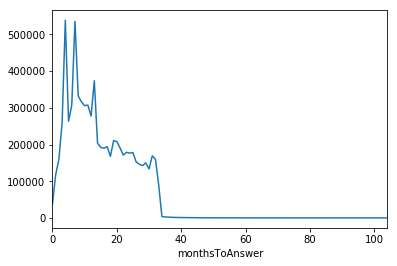

In [31]:
df3.groupby('monthsToAnswer').id.count().compute().plot()

In [32]:
df3['daysToAnswer'] = (df3['timeToAnswer'] / np.timedelta64(1, 'D')).astype(int)

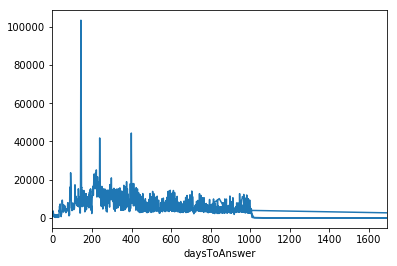

In [33]:
df3.groupby('daysToAnswer').id.count().compute().plot()

In [34]:
df3['weeksToAnswer'] = (df3['timeToAnswer'] / np.timedelta64(7, 'D')).astype(int)

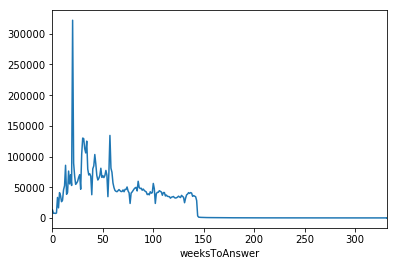

In [35]:
df3.groupby('weeksToAnswer').id.count().compute().plot()

In [39]:
# what is that spike about??
df3['weeksToAnswer'].value_counts().head(10)

20    322099
57    134402
30    130099
31    129221
34    125146
32    112733
33    105887
29    104154
42    103306
21     89336
Name: weeksToAnswer, dtype: int64

In [40]:
df3['daysToAnswer'].value_counts().head(10)

144    103396
143     74023
145     73203
146     47911
399     44390
239     41825
222     25098
400     25029
92      23607
218     23549
Name: daysToAnswer, dtype: int64